# Load dependencies

In [2]:
import pandas as pd
import numpy as np
import pickle
from urchin_workflow import urchin_prep
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier


# Load file

In [170]:
churnData=pd.read_csv(r'Data/DATA_Customer-Churn.csv')

# Check datatypes

In [171]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

## Fix TotalCharges to make it numeric

In [172]:
churnData['TotalCharges']=pd.to_numeric(churnData['TotalCharges'],errors='coerce')

In [173]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7032 non-null   float64
 15  Churn             7043 non-null   object 
dtypes: float64(2), int64(2), object(12)
memory

# Check missing values

In [174]:
dataframe=churnData.copy()
count_missing_val=dataframe.isnull().sum()
count_all_val=len(dataframe)
missing_ratio=(count_missing_val/count_all_val)*100
data={'column':count_missing_val.index,"# missing values":count_missing_val.values,"% missing values":missing_ratio}
count_missing_values_and_percent=pd.DataFrame(data)
count_missing_values_and_percent.reset_index(drop=True,inplace=True)

count_missing_values_and_percent.loc[count_missing_values_and_percent['% missing values']>0]



,column,# missing values,% missing values
14,TotalCharges,11,0.16


## Fix nan values

In [175]:
def d_nan_to_mean(dataframe,columns):
    integers_with_nan=columns
    df=dataframe.copy()
    #Loop through all columns in list, for each get the mean and fillna with mean
    for j in integers_with_nan:
        temp_mean=np.mean(df[j])
        df[j]=df[j].fillna(temp_mean)
    
    return df
churnData_cleaned=d_nan_to_mean(churnData,["TotalCharges"])

In [176]:
churn_key_features=churnData_cleaned[['tenure','SeniorCitizen','MonthlyCharges','TotalCharges','Churn']].copy()

In [177]:
churn_key_features.describe()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7043.00,7043.00
mean,32.37,0.16,64.76,2283.30
std,24.56,0.37,30.09,2265.00
min,0.00,0.00,18.25,18.80
25%,9.00,0.00,35.50,402.23
50%,29.00,0.00,70.35,1400.55
75%,55.00,0.00,89.85,3786.60
max,72.00,1.00,118.75,8684.80


## Adjust Churn to make it binary

In [178]:
churn_key_features['Churn']=churn_key_features['Churn'].map(dict(Yes=1,No=0))
churn_key_features['Churn'].unique()

array([0, 1], dtype=int64)

# X/Y split and standardize

In [179]:
def ca_prep_xy(dataframe,y_name,size_val=.3):
    
    #Prep X-Y Split
    y=dataframe[y_name]
    x=dataframe.drop(labels=y_name,axis=1)

    #Create train-test data using 'size_val' percent of test data
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=size_val,random_state=123)

    #Create transformer to normalize data
    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x_train)
    categorical_columns = categorical_columns_selector(x_train)

    categorical_preprocessor = OneHotEncoder(drop='first',handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    transformer = ColumnTransformer([('cat', categorical_preprocessor, categorical_columns),
                                      ('num', numerical_preprocessor, numerical_columns)],sparse_threshold=0)

    
    #Normalize/scale data
    x_train_scaled=transformer.fit_transform(x_train)
    x_test_scaled=transformer.transform(x_test)
    feature_names=transformer.get_feature_names_out()
    x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
    x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)
    
    with open("transformer.pickle", "wb") as f:
        pickle.dump(transformer,f)
    
    return x_train,y_train,x_train_scaled,x_test_scaled,y_test,x_test
y_name="Churn"
x_train,y_train,x_train_scaled,x_test_scaled,y_test,x_test = ca_prep_xy(churn_key_features,y_name)

# Conduct KNN Classifier

In [180]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10,weights='uniform')
model.fit(x_train_scaled, y_train)
y_pred=model.predict(x_test_scaled)
y_pred_train=model.predict(x_train_scaled)

## Show results

C:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


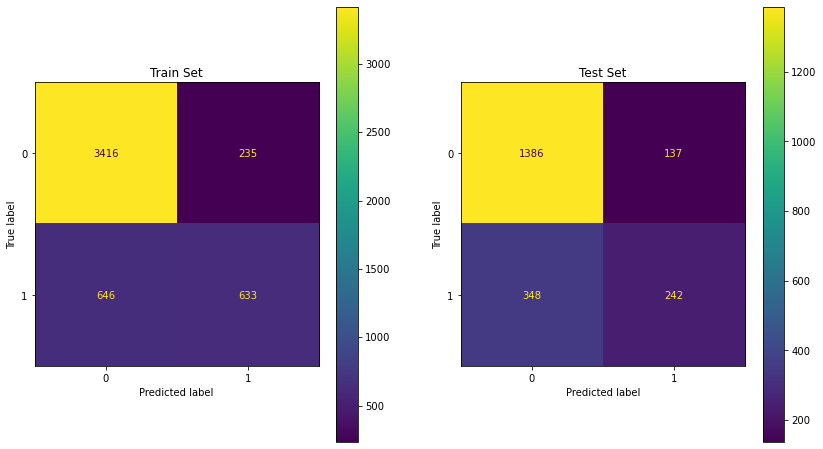

In [181]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1,2, figsize=(14,8))

plot_confusion_matrix(model,x_train_scaled,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

plot_confusion_matrix(model,x_test_scaled,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

# Conduct Decision Tree Classifier

In [204]:
model_DT = DecisionTreeClassifier(max_depth=4)
model_DT.fit(x_train, y_train)

y_pred_train_dt = model_DT.predict(x_train)
y_pred_test_dt = model_DT.predict(x_test)

## Check performance of decision tree

In [205]:
performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt),
                                         recall_score(y_train, y_pred_train_dt)],
                               'Test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt),
                                        recall_score(y_test, y_pred_test_dt)]})

display(performance_df)

,Error_metric,Train,Test
0,Accuracy,0.80,0.76
1,Precision,0.63,0.60
2,Recall,0.52,0.47


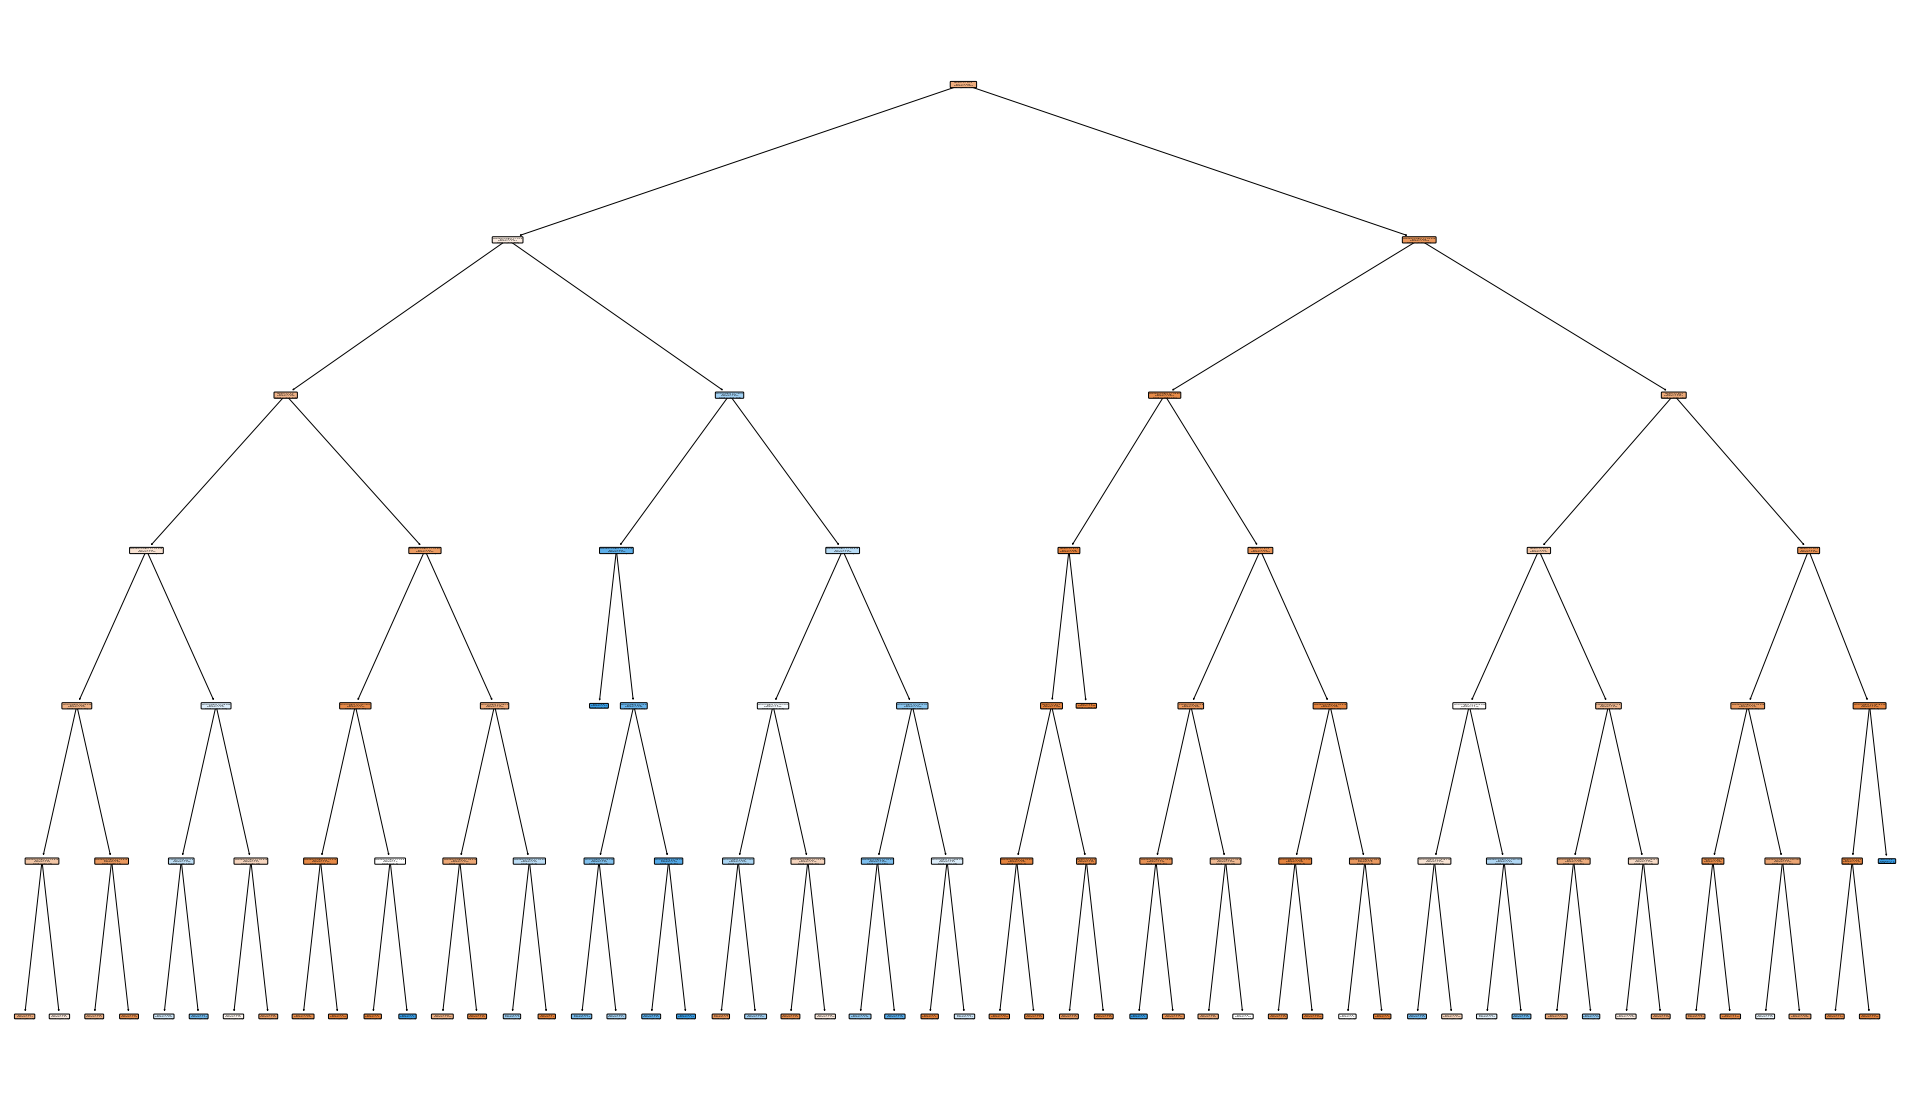

In [149]:
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(model_DT,filled = True, rounded=True,feature_names=x_train.columns)
plt.show() 